A pandas dataframe gén kölcsönhatásokat tartalmaz, ennek megfelelően 3 oszlopa van:

- gén_1
- kölcsönhatás típusa
- gén_2

A df alapján felépíthető egy gén kölcsönhatási gráf, aminek mindegyik csúcsa egy génnek, és mindegyik éle egy kölcsönhatásnak felel meg.
A gráfot ki is rajzoltam, a körvonalon vannak a csúcsok, közel 2M darab.

--2024-04-10 13:00:40--  https://www.pathwaycommons.org/archives/PC2/v12/PathwayCommons12.All.hgnc.sif.gz
Resolving www.pathwaycommons.org (www.pathwaycommons.org)... 142.150.84.100
Connecting to www.pathwaycommons.org (www.pathwaycommons.org)|142.150.84.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7405836 (7.1M) [application/x-gzip]
Saving to: ‘PathwayCommons12.All.hgnc.sif.gz’

PathwayCommons12.Al 100%[===================>]   7.06M  5.05MB/s    in 1.4s    

2024-04-10 13:00:42 (5.05 MB/s) - ‘PathwayCommons12.All.hgnc.sif.gz’ saved [7405836/7405836]

            0         2
0        A1BG       A2M
1        A1BG     ABCC6
2        A1BG      ACE2
3        A1BG    ADAM10
4        A1BG    ADAM17
...       ...       ...
1884844  ZZZ3  HIST1H3I
1884845  ZZZ3  HIST1H3J
1884846  ZZZ3  HIST2H3A
1884847  ZZZ3  HIST2H3C
1884848  ZZZ3  HIST2H3D

[1884849 rows x 2 columns]


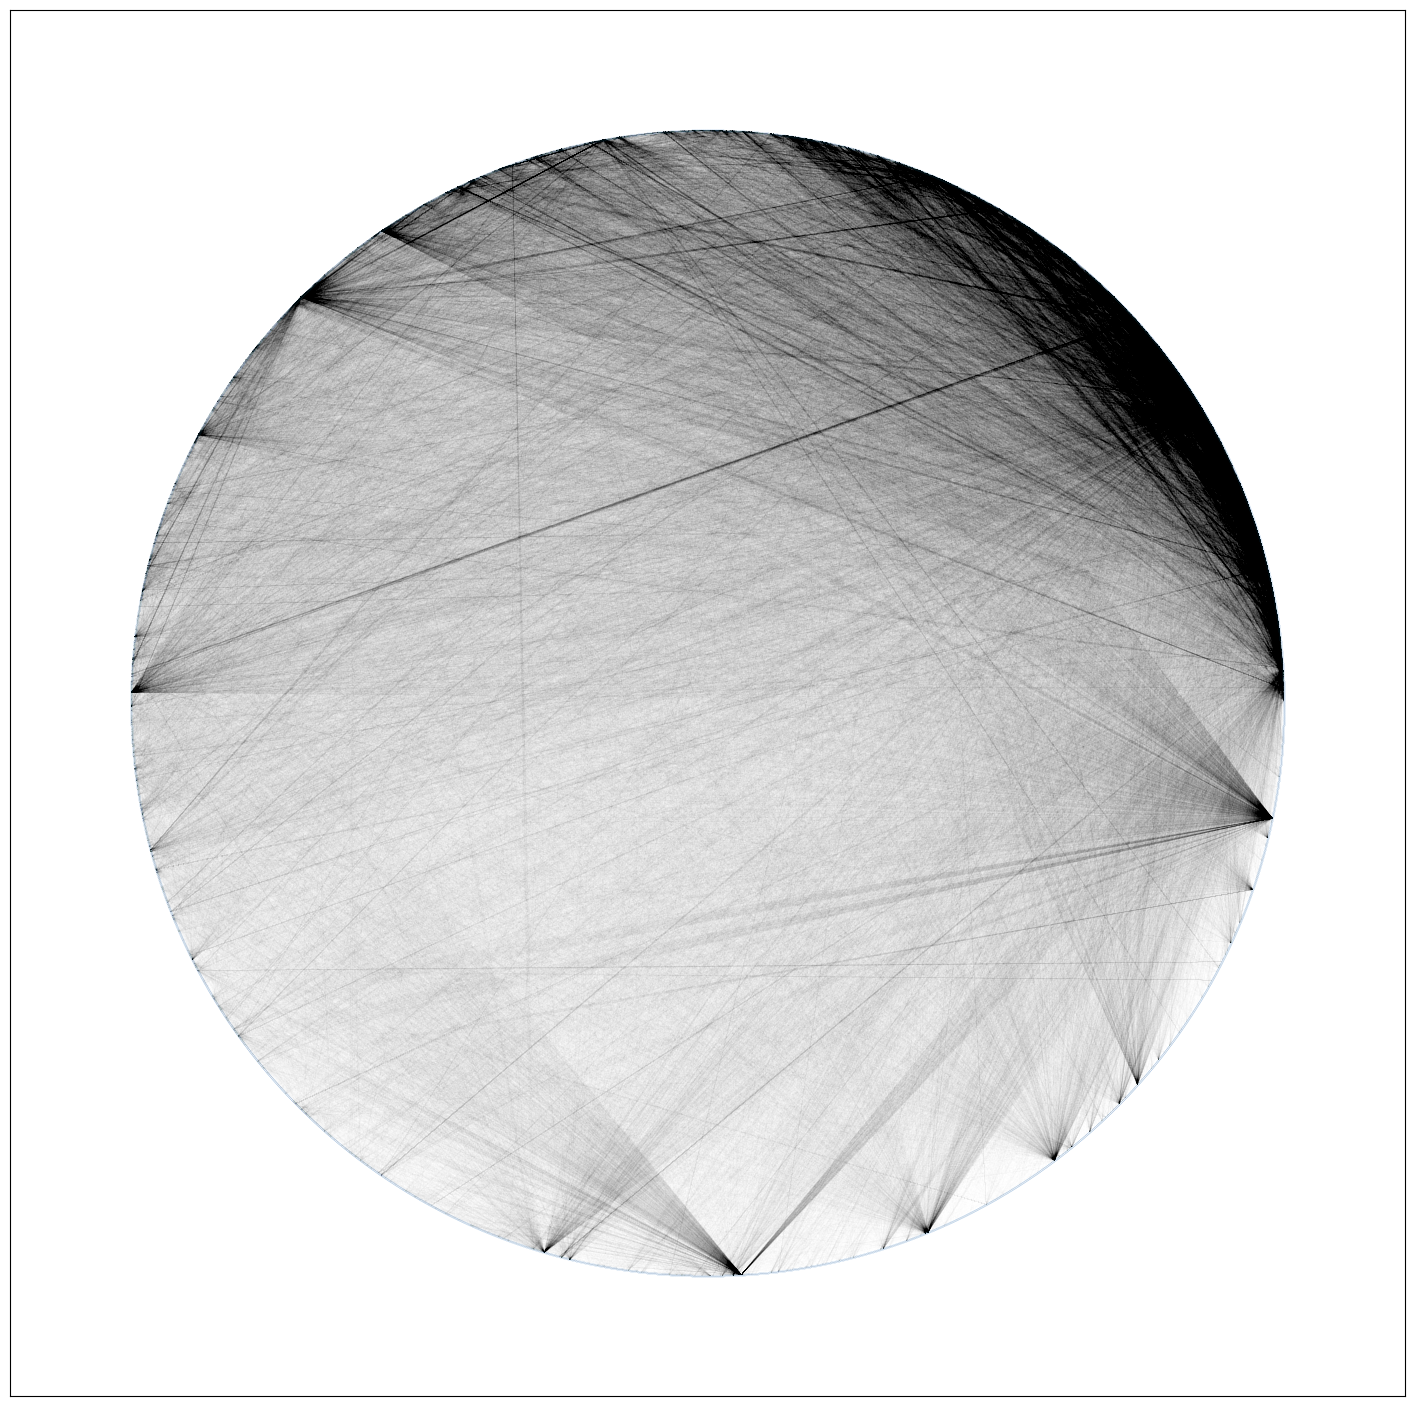

In [ ]:
!wget https://www.pathwaycommons.org/archives/PC2/v12/PathwayCommons12.All.hgnc.sif.gz
!gunzip PathwayCommons12.All.hgnc.sif.gz
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
df = pd.read_csv('PathwayCommons12.All.hgnc.sif', sep='\t', header=None)
df = df[[0, 2]] # we disregard the interaction type
print(df)
G = nx.from_edgelist(df.to_numpy())
pos = nx.circular_layout(G)
plt.figure(figsize=(18, 18))
nx.draw_networkx(G, pos, with_labels=False, node_size=0.0001, width=0.0001)


Itt a másik adatbázis, amiben rákos betegek génexpressziója van.
Ha megnézed a cBioPortal repository-t, sok-sok ráktípushoz/altípushoz van adat.
Itt amit behúzok, mellrák 6-féle altípusához a génexpresszió (vízszintes tengely) a különböző páciensekben (függőleges tengely).
Ránézésre nehéz lenne megmondani, hogy mi a különbség az altípusok között, de deeplearning hátha meg tudja mondani.

--2024-04-10 13:04:01--  https://media.githubusercontent.com/media/cBioPortal/datahub/master/public/brca_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem.txt
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154654152 (147M) [text/plain]
Saving to: ‘data_mrna_seq_v2_rsem.txt’

data_mrna_seq_v2_rs 100%[===================>] 147.49M  68.1MB/s    in 2.2s    

2024-04-10 13:04:10 (68.1 MB/s) - ‘data_mrna_seq_v2_rsem.txt’ saved [154654152/154654152]

--2024-04-10 13:04:10--  https://media.githubusercontent.com/media/cBioPortal/datahub/master/public/brca_tcga_pan_can_atlas_2018/data_clinical_sample.txt
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubuserconte

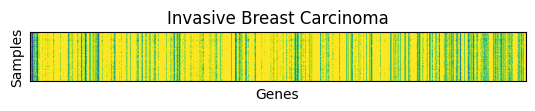

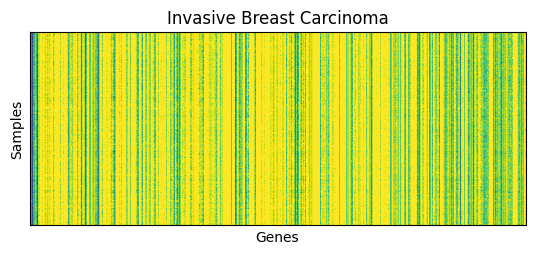

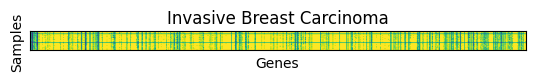

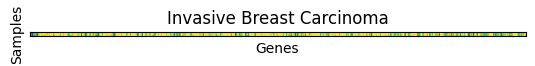

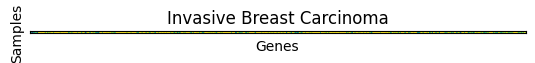

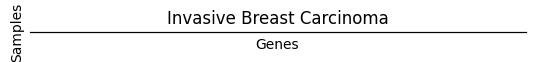

In [ ]:
!wget https://media.githubusercontent.com/media/cBioPortal/datahub/master/public/brca_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem.txt
!wget https://media.githubusercontent.com/media/cBioPortal/datahub/master/public/brca_tcga_pan_can_atlas_2018/data_clinical_sample.txt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df1 = pd.read_csv('data_clinical_sample.txt', sep='\t') \
    .drop(index=[0, 1, 2, 3])[['Sample Identifier', 'Cancer Type Detailed']]

df2 = pd.read_csv('data_mrna_seq_v2_rsem.txt', sep='\t') \
    .dropna() \
    .T \
    .drop(index=['Hugo_Symbol', 'Entrez_Gene_Id']) \
    .reset_index() \
    .rename(columns={'index':'Sample Identifier'})

df = pd.merge(df1, df2, on='Sample Identifier', how='left')
print(df)
for type_ in df['Cancer Type Detailed'].unique():
  data = df[df['Cancer Type Detailed'] == type_].to_numpy()[:, 2:].astype(np.float32)
  plt.title('Invasive Breast Carcinoma')
  plt.xticks([], [])
  plt.yticks([], [])
  plt.xlabel('Genes')
  plt.ylabel('Samples')
  plt.imshow(data[:, :2000] > 0) # show only for 2000 samples
  plt.show()


Szóval mindkét adatot fel akarjuk használni: gén kölcsönhatási hálózat + génexpressziós adatok.

Mindegyik pácienshez tartozik egy gén kölcsönhatási gráf, és a gráf csúcsaihoz, azaz a génekhez tartozik egy kifejeződési érték/intenzitás.

A gráfokat akarjuk osztályozni, rák típus/altípus szerint.

PyTorch Geometric introduction: https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html
Ebben nem gráf osztályozós példa van, de találsz olyan jellegű példákat is
*Graph classification with PyTorch Geometric* vagy hasonló jellegű kereséssel.